https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
datapath = 'data.csv'
df = pd.read_csv(datapath)
df.head()
df['label'].value_counts()

label
defacement    96457
benign        35378
spam          12000
malware       11566
phishing       9965
Name: count, dtype: int64

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'benign':0,
          'defacement':1,
          'phishing':2,
          'malware':3,
          'spam':4
          }

In [ ]:
df = df.sample(frac=0.003)

In [5]:
df['label'].value_counts()

label
defacement    96457
benign        35378
spam          12000
malware       11566
phishing       9965
Name: count, dtype: int64

<Axes: xlabel='label'>

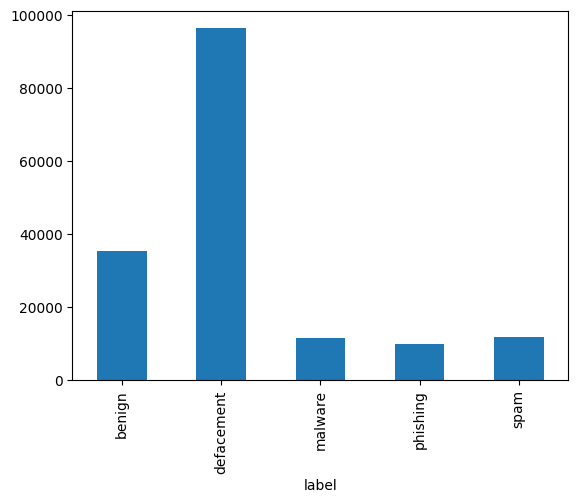

In [6]:
df.groupby(['label']).size().plot.bar()

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df,labels):

        self.data = df
        self.labels =labels


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        
        lb = self.data.iloc[idx]['label']
        text = self.data.iloc[idx]['url']
        tk =tokenizer(text,padding='max_length', max_length = 512, truncation=True,return_tensors="pt")

        return tk,torch.tensor(self.labels[lb],dtype=torch.long)

In [8]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

132292 16537 16537


In [9]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [10]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    model.train()

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_acc_history = []
    val_acc_history = []
    epoch_range = range(1, epochs + 1)

    for epoch_num in tqdm(epoch_range):
        total_acc_train = 0
        total_loss_train = 0

        for batch_num, (train_input, train_label) in enumerate(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc_val = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc_val

        # Calculate average accuracy for the epoch
        avg_acc_train = total_acc_train / len(train_dataloader.dataset)
        avg_acc_val = total_acc_val / len(val_dataloader.dataset)

        train_acc_history.append(avg_acc_train)
        val_acc_history.append(avg_acc_val)

        print(
            f'Epochs: {epoch_num} | Train Loss: {total_loss_train / len(train_dataloader):.3f} '
            f'| Train Accuracy: {avg_acc_train:.3f} '
            f'| Val Loss: {total_loss_val / len(val_dataloader):.3f} '
            f'| Val Accuracy: {avg_acc_val:.3f}')

    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_range, train_acc_history, label='Train Accuracy')
    plt.plot(epoch_range, val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [11]:
train_dt, val_dt = Dataset(df_train,labels), Dataset(df_val,labels)
len(df_train)

132292

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dt, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dt, batch_size=8)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [14]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")


CUDA is available.


In [15]:
!nvidia-smi

Fri May 26 01:03:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8               11W / 170W|    682MiB / 12288MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
EPOCHS = 5
LR = 1e-6          

In [17]:
model = BertClassifier()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#loading saved model
#model.load_state_dict(torch.load('bertmodel'))

In [ ]:
import gc
gc.collect()

 20%|███████████████▌                                                              | 1/5 [2:12:40<8:50:43, 7960.76s/it]

Epochs: 1 | Train Loss: 0.263 | Train Accuracy: 0.920 | Val Loss: 0.065 | Val Accuracy: 0.984


 40%|███████████████████████████████▏                                              | 2/5 [4:25:18<6:37:56, 7958.92s/it]

Epochs: 2 | Train Loss: 0.039 | Train Accuracy: 0.990 | Val Loss: 0.032 | Val Accuracy: 0.991


 60%|██████████████████████████████████████████████▊                               | 3/5 [6:37:55<4:25:15, 7957.99s/it]

Epochs: 3 | Train Loss: 0.021 | Train Accuracy: 0.994 | Val Loss: 0.020 | Val Accuracy: 0.994


 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [8:50:30<2:12:37, 7957.08s/it]

Epochs: 4 | Train Loss: 0.014 | Train Accuracy: 0.996 | Val Loss: 0.017 | Val Accuracy: 0.996


100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [11:03:28<00:00, 7961.62s/it]

Epochs: 5 | Train Loss: 0.009 | Train Accuracy: 0.997 | Val Loss: 0.015 | Val Accuracy: 0.996


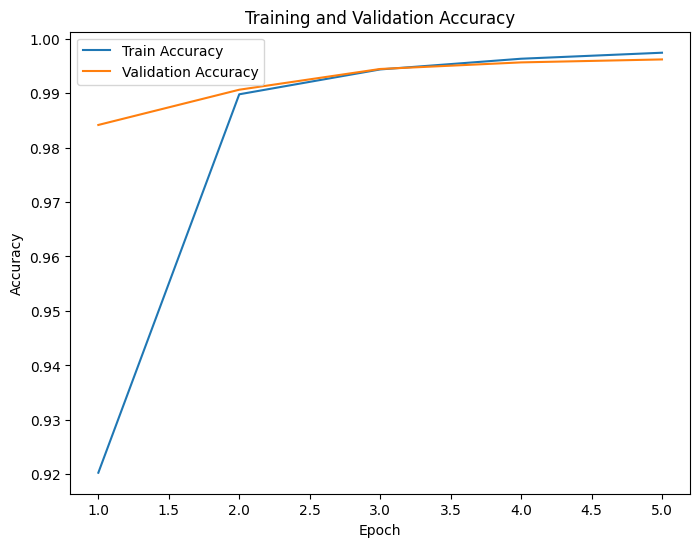

In [18]:
#to be run again
train(model, train_dataloader, val_dataloader, LR, EPOCHS)

In [19]:
#saving model
torch.save(model.state_dict(), 'pytorchmodel')

In [ ]:
model = BertClassifier()
#loading model
model.load_state_dict(torch.load('D:\Sara\pytorchmodel'))
#model.eval()

In [ ]:
#torch.save(model, 'model.pt')
#trainedmodel = torch.load('model.pt')
#trainedmodel.eval()

In [35]:
#torch.cuda.empty_cache()
#print(torch.cuda.is_available())
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [20]:
pip install scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [22]:
df_train['label'].nunique()

5

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(model, test_data, labels):
    test = Dataset(test_data, labels)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=256)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model = model.cuda()
    
    predictions = []
    targets = []
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            _, preds = torch.max(output, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            targets.extend(test_label.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(targets, predictions, labels=list(labels.values()))
    report = classification_report(targets, predictions, labels=list(labels.keys()), zero_division=0)
    accuracy = (np.array(targets) == np.array(predictions)).mean()
    
    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    print(f"\nAccuracy: {accuracy:.3f}")
        


    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, list(labels.values()), rotation=45)
    plt.yticks(tick_marks, list(labels.values()))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



In [36]:
evaluate(model, df_test, labels)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 12.00 GiB total capacity; 10.60 GiB already allocated; 0 bytes free; 10.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def evaluate(model, test_data, labels):

    test = Dataset(test_data,labels)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=256)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
evaluate(model, df_test, labels)